In [ ]:
""" The notebook will be used for the following analysis:
        1 - Adding the three bidding tickers in queues
        2 - Calculate the ground truth slippage
        3 - Model the order book with a normal log distribution as written in the answer
        4 - Calculate the slippage given a normal log distribution
        5 - Compare the error percentage in the ground truth and the modelled distribution
    Please keep in mind that due to the nature of the data (3 tickers only), the observations and modelling should do fine, 
    but it could do better with more (realistic) data"""

## 1 - Create the Order Book Class and add the bid and ask tickers

In [139]:
from queue import PriorityQueue

class OrderBook():
    """ This class represents an order book. It contains both data structures for bid and ask orders. 
        However, for calculations, only the bid order book will be used. The ask order book will be placed in reference to the data provided
        in the assignment and to find the mid price."""
    
    def __init__(self):
        """Defines an instance of the bid order book class.
           The orders will be represented with a priority queue data structure, 
           where the priority is the price (the higher the price, the faster the bid order gets fulfilled).
        """
        self.__bid_queue = PriorityQueue()
        self.__ask_queue = PriorityQueue()
        pass

    def place_limit(self, price, volume, book = "bid"):
        """
            Places a limit bid order at the given price and volume.

            Args: 
                price (float): The price per share to be placed in the bid order book
                volume (int): The number of shares to be placed in the bid order book
                book (optional, str): One of bid (add to the bid book) or ask (add to the ask book) 
        """
        # the price is negative in here because the priority queue sets highest priority based on the least entry, which adjusts the logic.
        if book.lower() == "bid":
            self.__bid_queue.put((-price, volume)) 
            
        elif book.lower() == "ask":
            self.__ask_queue.put((price, volume))

    def get_mid_price(self):

        """
            Returns:
                float: The mid price of the order book or None if the order  book is empty.
        """

        if self.__bid_queue.qsize() == 0 and self.__ask_queue.qsize() == 0:
            return None

        if self.__bid_queue.qsize() == 0:
            
            best_ask_tick = self.__ask_queue.get()
            mid_price = best_ask_tick[0]
            return mid_price

        if self.__ask_queue.qsize() == 0:
            
            best_bid_tick = self.__bid_queue.get()
            mid_price = - best_bid_tick[0]
            return mid_price

        best_bid_tick = self.__bid_queue.get()
        best_ask_tick = self.__ask_queue.get()

        mid_price = (best_ask_tick[0] - best_bid_tick[0]) / 2

        self.__bid_queue.put(best_bid_tick)
        self.__ask_queue.put(best_ask_tick)

        return mid_price
        
        

    def short_market(self, volume, inplace = False):
        """
            Sells a number of shares at a market order given the bid order book.
            
            Args:
                volume (int): The number of orders to be bought at market price
                inplace (bool): Represents whether to mutate the actual order book (Execute the order - T) or simulate the order (keep the queue as is - F)

            Returns:
                tuple(list[tuple], int) : A list of tuples that contain the price of each order bought and the volume bought at that price tick 
                                   and an integer that resembles the number of remaining orders that could not be placed (0 if all orders are executed)
        """
        complete_orders_list = []
        inplace_list = []
        remaining_volume = volume
        
        while remaining_volume != 0:
            
            if self.__bid_queue.qsize() == 0:
                
                if inplace:
                    for tick in inplace_list:
                        self.__bid_queue.put(tick)
    
                return complete_orders_list, remaining_volume

            curr_best_tick = self.__bid_queue.get()
            inplace_list.append(curr_best_tick)
            curr_best_price = curr_best_tick[0]
            curr_best_volume = curr_best_tick[1]

            if curr_best_volume >= remaining_volume:
                complete_orders_list.append((-curr_best_price, remaining_volume))
                
                if curr_best_volume > remaining_volume and not inplace:
                    self.__bid_queue.put((curr_best_price, curr_best_volume))
                    
                remaining_volume = 0

            else:

                complete_orders_list.append((-curr_best_price, curr_best_volume))
                remaining_volume -= curr_best_volume
                
        if inplace:
            for tick in inplace_list:
                self.__bid_queue.put(tick)
                
        return complete_orders_list, remaining_volume

    def get_slippage(self, volume, exec_order = False):
        """
            Executes the sell order at a given volume and returns the slippage
            
            Args:
                volume (int): The volume of stocks to be shorted / selled.
                exec_order (bool): Indicates whether the order should actually be executed (True) or just calculate the slippage in place (False).
                
            Returns:
                float: The slippage assuming a market short order with the given volume is placed or None if the order could not be placed (partially or fully)
        """
        
        mid_price = self.get_mid_price()
        
        if mid_price == None:
            return None
            
        sim_exec_orders = self.short_market(volume, inplace= not exec_order)
        orders_list = sim_exec_orders[0]
        remaining_orders = sim_exec_orders[1]
        
        if orders_list == []:
            return None

        no_exec_orders = volume - remaining_orders # how many actual orders can be placed..

        if no_exec_orders == 0: # Should never be True
            return None 

        slippage = sum( [(mid_price - tick_price) * tick_volume for tick_price, tick_volume in orders_list] ) / no_exec_orders
        return slippage

    def get_c_i(self, tick_price_delta):
        """
            Gets the units of x in the lognorm function as discussed in the document.

            Args:
                tick_price_delta (float): Represents the minimum possible change in the price between any two consecutive ticks at any time

            Returns:
                list[int]: A list of integers representing the units to be plotted in the lognorm function
        """

        inplace_list = []
        lognorm_x_list = []

        if self.__bid_queue.qsize() != 0:
            tick = self.__bid_queue.get()
            inplace_list.append(tick)
            T_0 =  - tick[0]
            lognorm_x_list.append(0)
            
            while self.__bid_queue.qsize() != 0:
                
                tick = self.__bid_queue.get()
                inplace_list.append(tick)
                lognorm_x_list.append( (T_0 + tick[0]) / tick_price_delta)

        for tick in inplace_list:
            self.__bid_queue.put(tick)
            
        return lognorm_x_list

    def get_total_orders(self, book = "bid"):

        """
            Args: 
                book (string): Either the bid or ask book should be the input. Default value is bid.
            Returns:
                int: The total number of orders in the book (bid or ask book)
        """

        inplace_list = []
        total_orders = 0
        if book.lower() == "bid":

            while self.__bid_queue.qsize() != 0:
                tick = self.__bid_queue.get()
                inplace_list.append(tick)
                total_orders += tick[1]

            for tick in inplace_list:
                self.__bid_queue.put(tick)

        elif book.lower() == "ask":
            
            while self.__ask_queue.qsize() != 0:
                tick = self.__ask_queue.get()
                inplace_list.append(tick)
                total_orders += tick[1]

            for tick in inplace_list:
                self.__ask_queue.put(tick)

        return total_orders    
        

## 2 - Add the given three tickers data to the order book and calculate the slippage for all possible market orders

In [140]:
import numpy as np
import matplotlib.pyplot as plt

TOTAL_BID_ORDERS = 112 + 138 + 200
slippage_array = np.zeros(shape = TOTAL_BID_ORDERS)

sample_order_book = OrderBook()    
sample_order_book.place_limit(80.93, 112, book = "bid")
sample_order_book.place_limit(80.92, 138, book = "bid")
sample_order_book.place_limit(80.91, 200, book = "bid")

sample_order_book.place_limit(80.97, 110, book = "ask")
sample_order_book.place_limit(80.99, 123, book = "ask")
sample_order_book.place_limit(81.00, 140, book = "ask")

for i in range(TOTAL_BID_ORDERS): 

    slippage_i_orders = sample_order_book.get_slippage(i + 1, exec_order = False)
    slippage_array[i] = slippage_i_orders
    


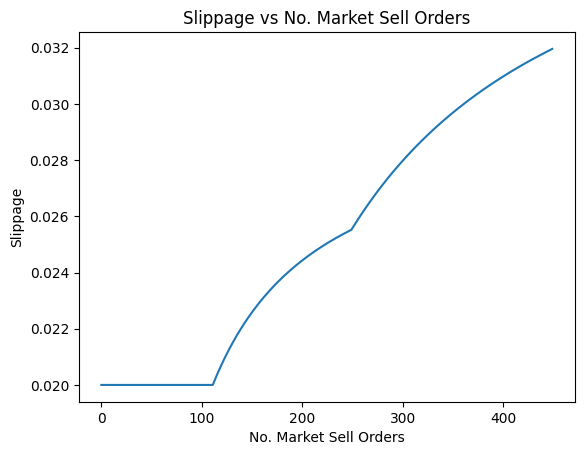

In [141]:
plt.title("Slippage vs No. Market Sell Orders")
plt.xlabel("No. Market Sell Orders")
plt.ylabel("Slippage")

plt.plot(range(TOTAL_BID_ORDERS), slippage_array)

## 3 - Model the order book with the log normal distribution

In [171]:
from scipy.stats import lognorm

#WE WILL SET THE STANDARD DEVIATION TO BE 1 
STD = 1

#THE MINIMUM DELTA IN TICK PRICES IN THE BID ORDER BOOK
TICK_PRICE_DELTA = 0.01

#CONSTANT HYPERPARAMETERS DEFINED IN THE DOCUMENT (THEY ARE TUNED FOR NOW)
ALPHA = 1 / 8
BETA = 1 / 8

c_i_list = np.array(sample_order_book.get_c_i(TICK_PRICE_DELTA)) * ALPHA + BETA


v_i_list = lognorm.pdf(x = c_i_list, s = STD)

v_i_ratios = v_i_list / np.sum(v_i_list)

#This is the estimated volume order at each tick given that STD is 1 (assumed but calculation will be provided in the second question) and price delta
v_list = sample_order_book.get_total_orders(book = "bid") * v_i_ratios

v_i_rounded = [round(v_i) for v_i in v_list.tolist()] # round the values to the closest integer

v_i_rounded

[101, 168, 181]

## Time to test the slippage and the error with the ground truth

In [182]:
sample_order_book_2 = OrderBook()    
sample_order_book_2.place_limit(80.93, v_i_rounded[0], book = "bid")
sample_order_book_2.place_limit(80.92, v_i_rounded[1], book = "bid")
sample_order_book_2.place_limit(80.91, v_i_rounded[2], book = "bid")

sample_order_book_2.place_limit(80.97, 110, book = "ask")
sample_order_book_2.place_limit(80.99, 123, book = "ask")
sample_order_book_2.place_limit(81.00, 140, book = "ask")

In [183]:
TOTAL_BID_ORDERS = 112 + 138 + 200
slippage_array_2 = np.zeros(shape = TOTAL_BID_ORDERS)

for i in range(TOTAL_BID_ORDERS): 

    slippage_i_orders = sample_order_book_2.get_slippage(i + 1, exec_order = False)
    slippage_array_2[i] = slippage_i_orders

## THE PLOT BELOW SHOWS THE DIFFERENCE BETWEEN THE ESTIMATED SLIPPAGE FROM MY MODEL AND THE ACTUAL SLIPPAGE

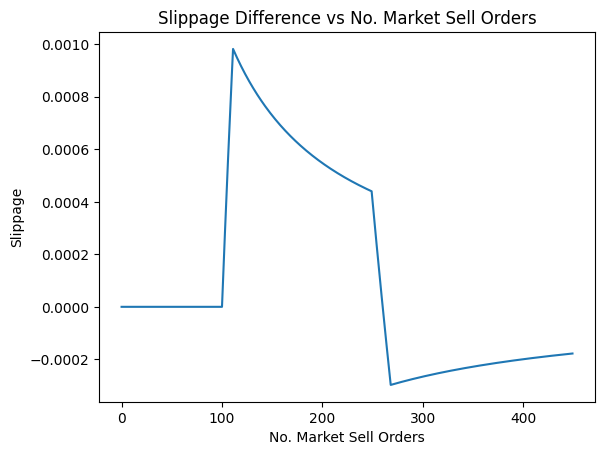

In [186]:
plt.title("Slippage Difference vs No. Market Sell Orders")
plt.xlabel("No. Market Sell Orders")
plt.ylabel("Slippage")

plt.plot(range(TOTAL_BID_ORDERS), slippage_array_2 - slippage_array)


## Below is the same plot, but it is plotted in % of error

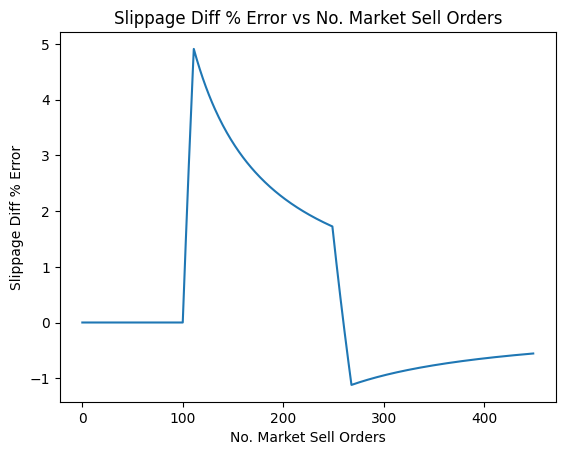

In [187]:
plt.title("Slippage Diff % Error vs No. Market Sell Orders")
plt.xlabel("No. Market Sell Orders")
plt.ylabel("Slippage Diff % Error")

plt.plot(range(TOTAL_BID_ORDERS), (slippage_array_2 - slippage_array) / slippage_array * 100)

# Conclusion:

## 1 - The log normal distribution is able to model well the characteristics of the order book given the STD, alpha, and beta parameters.

### While the data is small and the hyperparameters are minimally tuned, this model gives promise to predict the volume of order books per tick prices at any given time
---
## 2 - The error rate of the difference between slippages between my predicted model and the ground truth reaches 5% at maximum.

### However, 5% is not a small value, and in real applications, the actual effect or extra cost can be figured out by EVALUATING THE INTEGRAL of the slippage difference plot above, as it shows how these small differences in errors can accumulate over orders and cause more losses, especially for large orders. Nevertheless, since the data is synthetic and small, no hypothesis can be formed regarding the % difference or the integral.

<br>